<a href="https://colab.research.google.com/github/jakey1610/MachineLearningL3/blob/master/peg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Create class to add random gaussian noise for PA**

In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

**Import dataset**

In [88]:
# helper function to make getting another batch of data easier
trans = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
          transforms.RandomApply([AddGaussianNoise(0, 0.1)], p=0.01)
      ])

def reload_train(ld,prob):
  trans = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
          transforms.RandomApply([AddGaussianNoise(0, 0.1)], p=prob)
      ])
  for l in ld.dataset:
    to_pil = torchvision.transforms.ToPILImage()
    x = to_pil(l[0])
    l = (trans(x),l[1])
  return iter(cycle(ld))

def cycle(iterable):
    while True:
        for x in iterable:
            yield x
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_set = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=trans)

#Scan through to get idx
idx = []
weight = []
for i in range(len(train_set)):
  if train_set[i][1] in [0,2,7]:
    idx.append(i)
  if train_set[i][1] == 0:
    weight.append(0.2)
  elif train_set[i][1] == 2:
    weight.append(0.2)
  elif train_set[i][1] == 7:
    weight.append(0.6)
  else:
    weight.append(0)

sampler = WeightedRandomSampler(weight,10000,replacement=True)
train_loader = torch.utils.data.DataLoader(train_set,
batch_size=64, sampler=sampler)

train_iterator = iter(cycle(train_loader))
prob = 0.01

print(f'> Size of training dataset {len(train_loader.dataset)}')

Files already downloaded and verified
> Size of training dataset 10000


**View some of the test dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


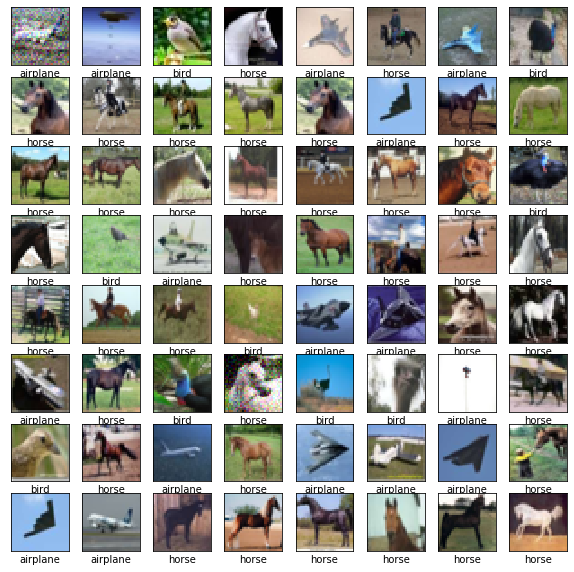

In [89]:
plt.figure(figsize=(10,10))
x,t = next(train_iterator)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[t[i]])


**Define the Generator and Discriminator Networks**

In [0]:
class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(100, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*8, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            nn.ConvTranspose2d(f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, f, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f, f*2, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*2, f*4, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*4, f*8, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*8, 3, 3, 1, 1)),
            #Potentially look into replacing w/ BCEwithLogitsLoss
            nn.Sigmoid()
        )
        

**Initialise the Optimisers**

In [0]:
GN = Generator().to(device)
DN = Discriminator().to(device)
# initialise the optimisers
optimiser_G = torch.optim.Adam(GN.parameters(), lr=0.001, betas=(0.5, 0.999))
optimiser_D = torch.optim.Adam(DN.parameters(), lr=0.001, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

epoch = 0
liveplot = PlotLosses()

**Training Loops For SNAP-GAN**

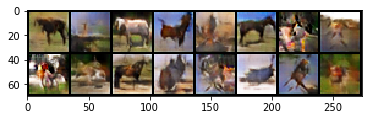

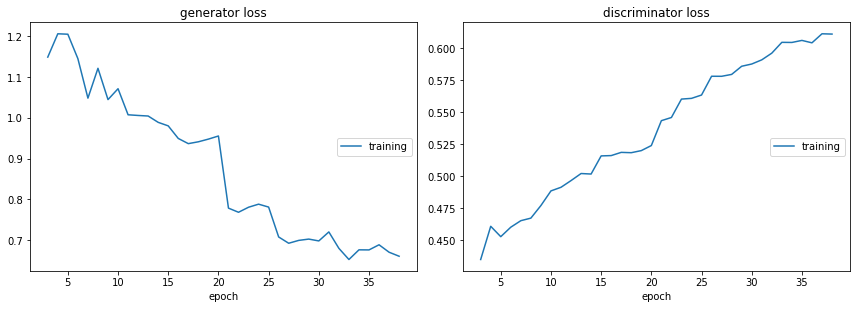

generator loss:
training   (min:    0.652, max:    1.490, cur:    0.661)

discriminator loss:
training   (min:    0.360, max:    0.611, cur:    0.611)
5
[0.67622193 0.67602382 0.68860851 0.67035029]
0.6778011370077729
0.660516962558031


In [0]:
# training loop
maxE = 50
load_G = 'GN_SNAP.pth'
load_D = 'DN_SNAP.pth'
load = False

prevLoss = np.array([5,5,5,5,5,5])

#Load checkpoint model if load boolean true
if load:
  # Load Generator
  GN = Generator().to(device)
  optimiser_G = torch.optim.Adam(GN.parameters(), lr=0.001, betas=(0.5, 0.999))

  checkpoint = torch.load(load_G)
  GN.load_state_dict(checkpoint['state_dict'])
  optimiser_G.load_state_dict(checkpoint['optimiser_state_dict'])
  epoch = checkpoint['epoch']
  loss_g = checkpoint['loss']

  GN.train()
  # Load Discriminator
  DN = Discriminator().to(device)
  optimiser_D = torch.optim.Adam(DN.parameters(), lr=0.001, betas=(0.5, 0.999))

  checkpoint = torch.load(load_D)
  DN.load_state_dict(checkpoint['state_dict'])
  optimiser_D.load_state_dict(checkpoint['optimiser_state_dict'])
  loss_d = checkpoint['loss']

  DN.train()
dTrain = 5
gTrain = 1
incF = True
while (epoch<maxE):
    print(gTrain)
    # Checkpoints saved every 10 epochs
    if epoch%10 == 0 and epoch != 0:
      print("saving checkpoint...")
      PATH_DN = './DN_SNAP.pth'
      torch.save({
          "state_dict": DN.state_dict(),
          "epoch": epoch,
          "loss": loss_d,
          "optimiser_state_dict": optimiser_D.state_dict()
      }, PATH_DN)
      PATH_GN = './GN_SNAP.pth'
      torch.save({
          "state_dict": GN.state_dict(),
          "epoch": epoch,
          "loss": loss_g,
          "optimiser_state_dict": optimiser_G.state_dict()
      }, PATH_GN)

    # Progressively augment the images that the discriminator trains on
    if epoch%2 == 0 and epoch != 0:
      prob += (0.5-prob)/(maxE//2)
      train_iterator = reload_train(train_loader, prob)


    # arrays for metrics
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)
    exp_rep = None
    # iterate over some of the train dateset
    for i in range(200):
        # train discriminator 
        for j in range(dTrain):
            x,t = next(train_iterator)
            x,t = x.to(device), t.to(device)
            optimiser_D.zero_grad()
            g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            l_r = bce_loss(DN.discriminate(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
            l_f = bce_loss(DN.discriminate(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
            loss_d = (l_r + l_f)/2.0
            loss_d.backward()
            optimiser_D.step()
          
        # train generator
        for j in range(gTrain):
          x,t = next(train_iterator)
          x,t = x.to(device), t.to(device)
          optimiser_G.zero_grad()
          g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
          exp_rep = g
          loss_g = bce_loss(DN.discriminate(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
          loss_g.backward()
          optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())
    prevLoss = np.append(prevLoss, gen_loss_arr.mean())
    if prevLoss[-5:-1].mean() <= prevLoss[-1]:
              gTrain += 1

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'generator loss': gen_loss_arr.mean(),
        'discriminator loss': dis_loss_arr.mean()
    })
    liveplot.draw()
    epoch = epoch+1

In [0]:
g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
img = g
save_image(img, 'img.png')


**Save the trained model**

In [0]:
#Save the trained model
PATH_DN = './DN_PEG_cifar_net.pth'
torch.save(DN.state_dict(), PATH_DN)
PATH_GN = './GN_PEG_cifar_net.pth'
torch.save(GN.state_dict(), PATH_GN)